

#



#extract data 



In [ ]:
# !unzip "/content/drive/My Drive/NADI-2020_release_1.0.zip"


In [ ]:
import numpy as np
from collections import Counter
import pandas as pd
import pickle

import nltk

nltk.download("stopwords")
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))
train_data=pd.read_csv("/content/NADI_release/train_labeled.tsv",delimiter='\t',encoding='utf-8')
new_names={"#1 tweet_ID":"id","#2 tweet_content":"tweet","#3 country_label":'country_label',"#4 province_label":"province_label"}
train_data=train_data.rename(columns=new_names)
valid_data=pd.read_csv("/content/NADI_release/dev_labeled.tsv",delimiter='\t',encoding='utf-8')
valid_data=valid_data.rename(columns=new_names)

train_data=train_data.drop(columns=['id','province_label']) #we don't need second task label 
valid_data=valid_data.drop(columns=['id','province_label']) #we don't need second task label 

from sklearn.neighbors import NeighborhoodComponentsAnalysis,KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from sklearn.pipeline import Pipeline
import seaborn as sns
def plot_cov_matrix(y_valid,pred):
  con_mat=confusion_matrix(y_valid,pred)
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                     index =np.unique(y_valid), 
                     columns = np.unique(y_valid))
  figure = plt.figure(figsize=(15,15))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  print(accuracy_score(y_valid,pred))
  print(f1_score(y_valid,pred, average='macro'))

def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 
        
x_train=np.array(train_data.tweet)
x_valid=np.array(valid_data.tweet)
y_train=np.array(train_data.country_label)
y_valid=np.array(valid_data.country_label)
# coding=utf-8
import re
import string
import sys
english_char=list(string.printable[:-38])
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)




def remove_links(text):
  text = re.sub(r'http\S+', '', text)
  return text
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text
def remove_english(text):
    for char in english_char:
      text =re.sub(char, '', text)  
    return text
def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
def remove_stop_words(tweet):    
    for word in tweet.split(" "):
          if word  in arb_stopwords:  
            tweet=tweet.replace(word,"")
    return tweet

def pre_process_document(text):
  text = remove_links(text)
  text = remove_punctuations(text)
  text = remove_stop_words(text)
  text = remove_diacritics(text)
  text = remove_repeating_char(text)
  text = remove_english(text)

  return text

pre_x_train=[]  
pre_x_valid=[]
for tweet in x_train:
  pre_x_train.append(pre_process_document(tweet))
for tweet in x_valid:
  pre_x_valid.append(pre_process_document(tweet))
pre_x_train=np.array(pre_x_train)
pre_x_valid=np.array(pre_x_valid)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#TFIDF features

##feature union

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

estimators = [('word', TfidfVectorizer(ngram_range=(1,1),max_df=0.05,min_df=0.0001,stop_words=arb_stopwords)), ('char_b', TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char_wb',
    ngram_range=(2, 9),
    max_features=40000)),('char', TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char_wb',
    ngram_range=(2, 9),
    max_features=40000)) ]
combined = FeatureUnion(estimators)
x_train_comb = combined.fit_transform(pre_x_train, y_train)
x_valid_comb=combined.transform(pre_x_valid)


here


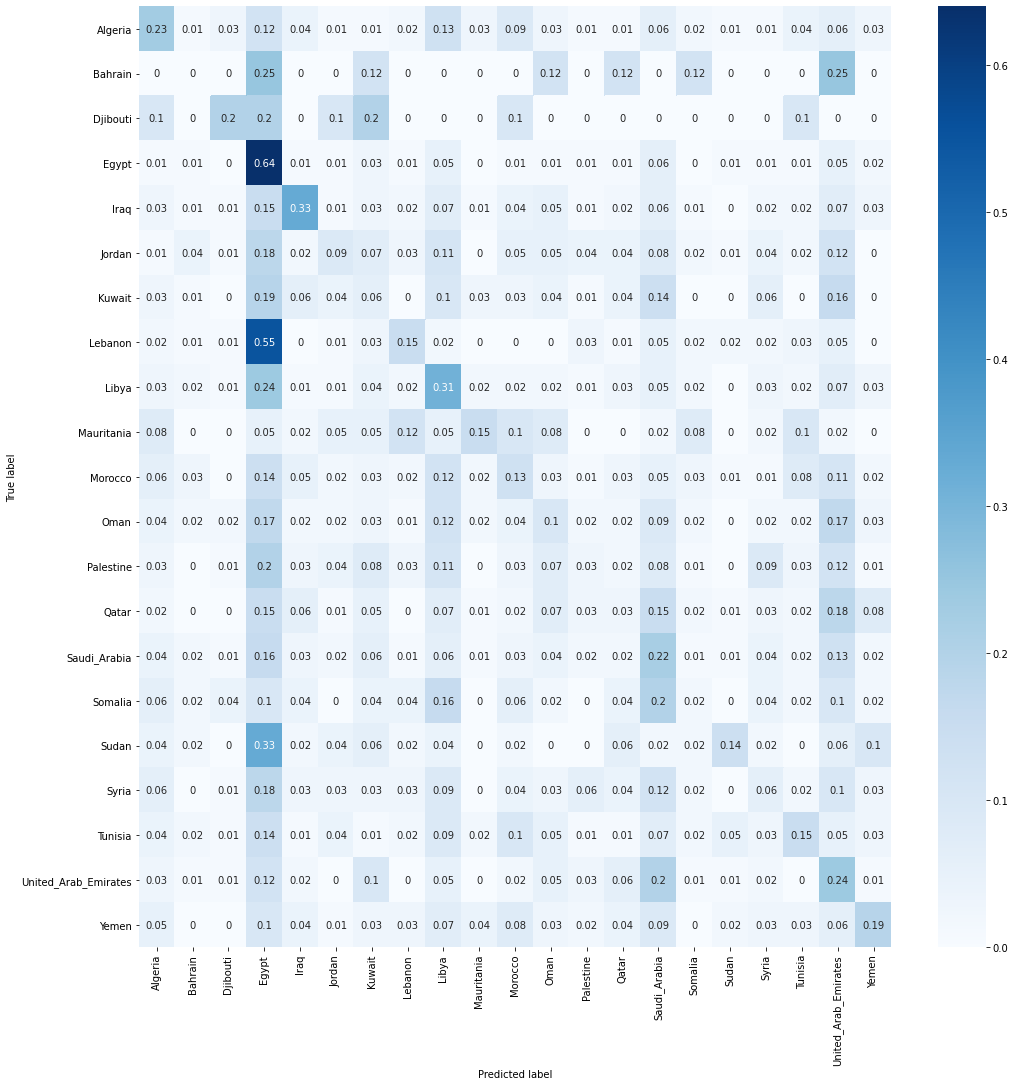

0.2925156344563244
0.1603562818856031


In [ ]:
from sklearn.naive_bayes import BernoulliNB
ber_nb = BernoulliNB(alpha=.1)
#kan 29 w 
for batch in zip(divide_chunks(x_train_comb.toarray(),21),divide_chunks(y_train,21)):
  x,y=batch
  ber_nb.partial_fit(x, y,classes=np.unique(y_train))
print('here')
ber_pred=[]
for x in divide_chunks(x_valid_comb.toarray(),21):
  pr =ber_nb.predict(x)
  ber_pred.extend(pr)

# mn_nb_pred=mn_nb.predict(x_valid_trans)
plot_cov_matrix(y_valid,ber_pred)

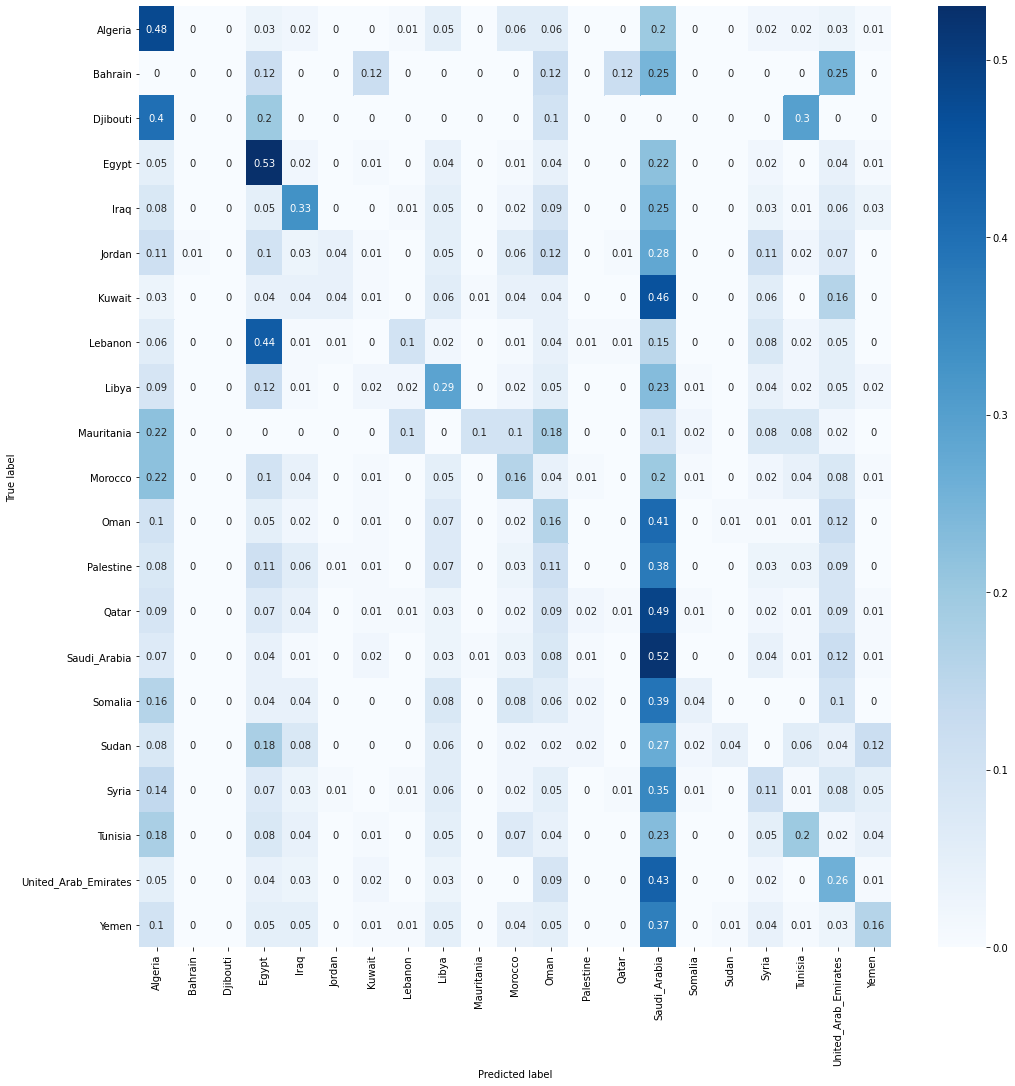

0.3219689328222715
0.17274955321343607


In [ ]:
from sklearn.ensemble import RandomForestClassifier  #naive trial
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
#charachter 2,8 Max features =40000
# after preprocessing
svc_clf_word = svm.SVC(decision_function_shape='ovo',class_weight='balanced',cache_size=4000)  


svc_clf_word.fit(x_train_comb, y_train)
svc_pred=svc_clf_word.predict(x_valid_comb)
plot_cov_matrix(y_valid,svc_pred)
filename = 'finalized_model.sav'

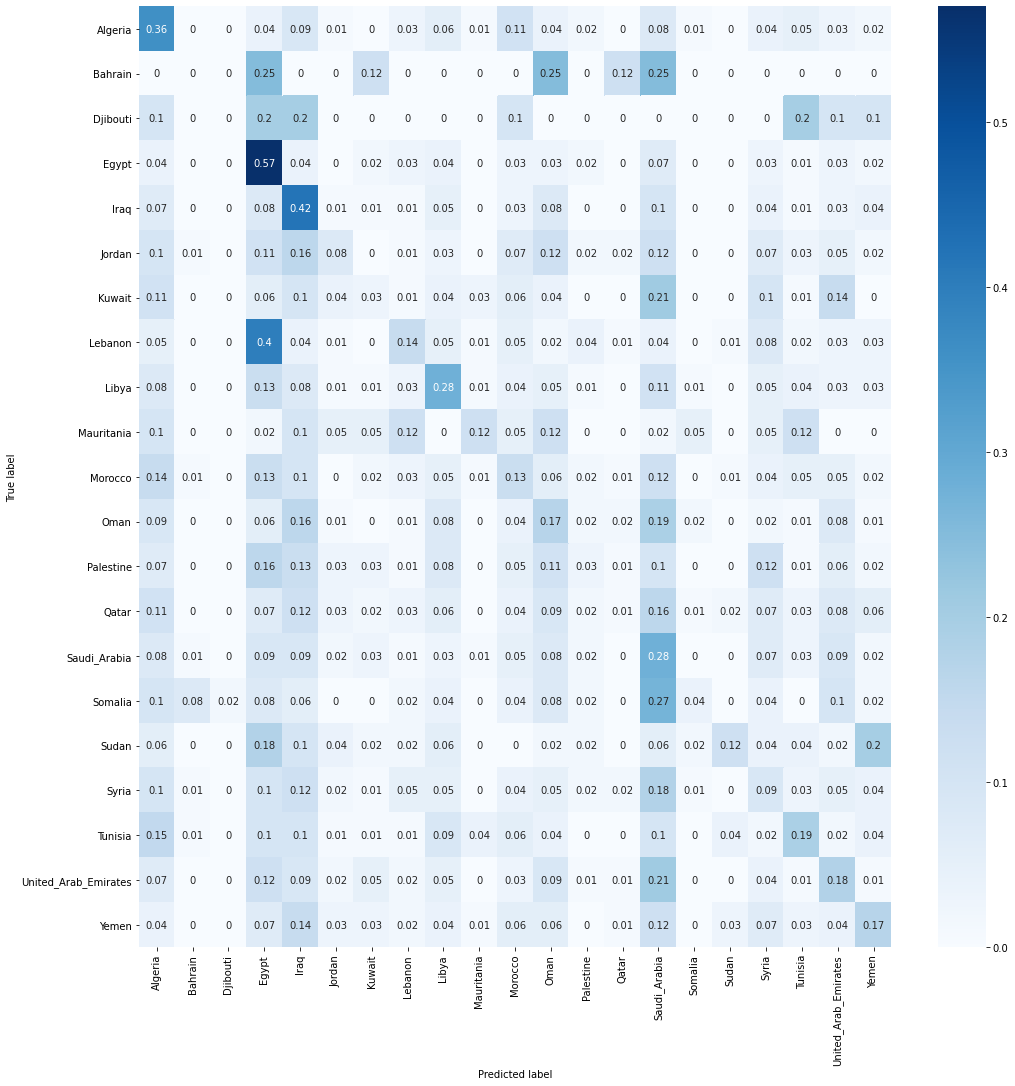

0.30340932015331856
0.1633715269184735


In [ ]:
from sklearn.ensemble import RandomForestClassifier  #naive trial
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
#charachter 2,8 Max features =40000
# after preprocessing
svc_clf_linear = svm.SVC(decision_function_shape='ovo',kernel='linear',class_weight='balanced',cache_size=4000)  


svc_clf_linear.fit(x_train_comb, y_train)
svc_pred=svc_clf_linear.predict(x_valid_comb)
plot_cov_matrix(y_valid,svc_pred)
filename = 'finalized_model.sav'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


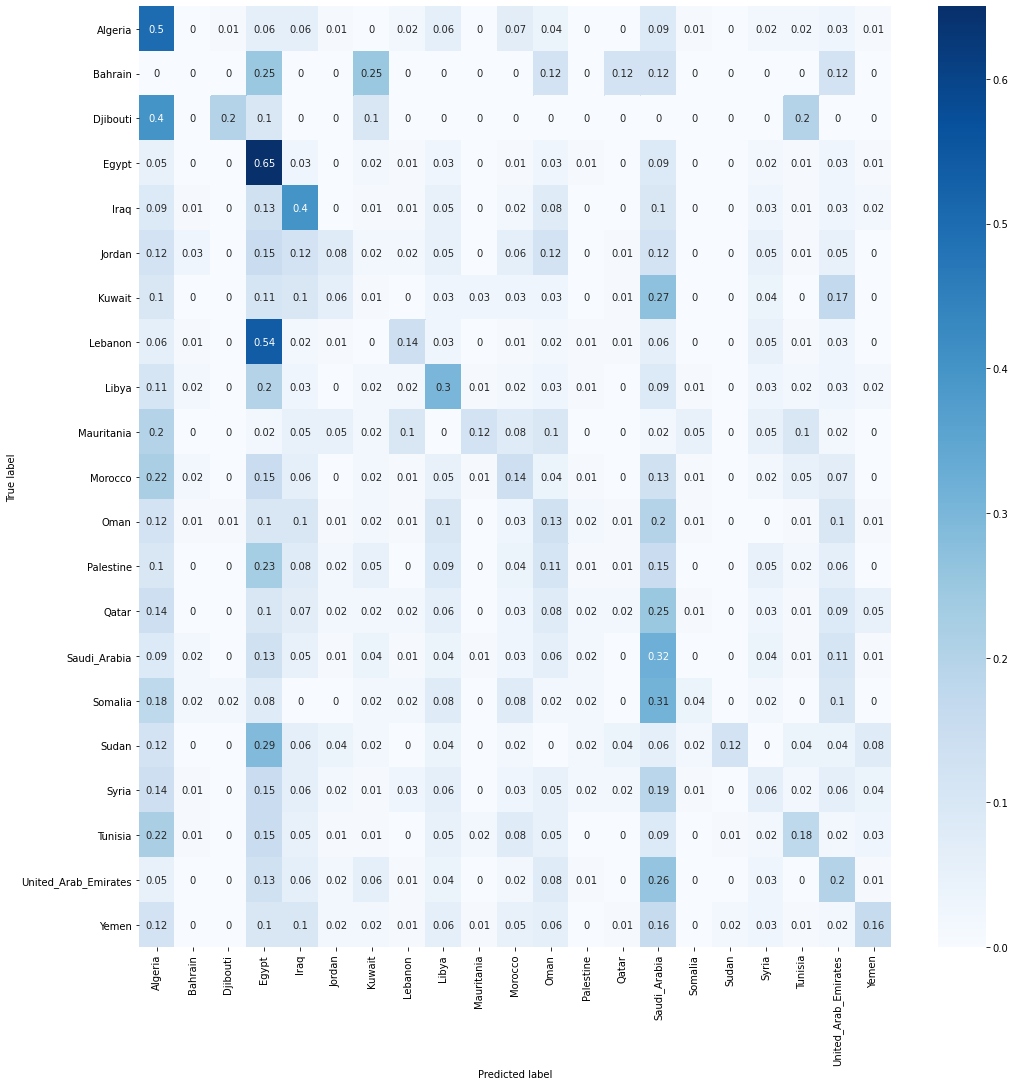

0.3296348597942304
0.18110319105030342


In [ ]:
from mlxtend.classifier import EnsembleVoteClassifier
voting_clf = EnsembleVoteClassifier(clfs=[svc_clf_word,svc_clf_linear,ber_nb], weights=[1,1,1], refit=False)
voting_clf.fit(x_train_comb, y_train)
vote_pred=voting_clf.predict(x_valid_comb)
plot_cov_matrix(y_valid,vote_pred)